In [1]:
# Install required packages
%pip install pdfminer.six pandas spacy tensorflow scikit-learn matplotlib joblib fuzzywuzzy python-Levenshtein PyPDF2
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\keepu\Downloads\Analysing-of-Resumes\myenv\Scripts\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.0/12.8 MB 279.3 kB/s eta 0:00:46
     --------------------------------------- 0.1/12.8 MB 654.9 kB/s eta 0:00:20
     - -------------------------------------- 0.4/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.8 MB 3.5 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 3.6 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.6 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.5 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.5 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.5 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 2.7 M


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import os
import re
import pandas as pd
import numpy as np
from pdfminer.high_level import extract_text
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Skill set
SKILL_SET = {'tensorflow', 'keras', 'pytorch', 'machine learning', 'deep learning', 'flask', 'streamlit', 'react', 'django', 'node js', 'react js', 'php', 'laravel', 'magento', 'wordpress', 'javascript', 'angular js', 'c#', 'android', 'android development', 'flutter', 'kotlin', 'xml', 'kivy', 'ios', 'ios development', 'swift', 'cocoa', 'cocoa touch', 'xcode', 'ux', 'adobe xd', 'figma', 'zeplin', 'balsamiq', 'ui', 'prototyping', 'wireframes', 'storyframes', 'adobe photoshop', 'photoshop', 'editing', 'adobe illustrator', 'illustrator', 'adobe after effects', 'after effects', 'adobe premier pro', 'premier pro', 'adobe indesign', 'indesign', 'wireframe', 'solid', 'grasp', 'user research', 'user experience', 'aws', 'google cloud platform', 'microsoft azure', 'docker', 'kubernetes', 'jenkins', 'github actions', 'terraform', 'ci/cd', 'ansible', 'apache spark', 'apache kafka', 'hadoop', 'airflow', 'snowflake', 'etl', 'dbt', 'pandas', 'numpy', 'mysql', 'postgresql', 'mongodb', 'sqlite', 'redis', 'firebase', 'cassandra', 'elasticsearch', 'next.js', 'vue.js', 'svelte', 'tailwind css', 'bootstrap', 'rest api', 'graphql', 'websockets', 'typescript', 'go', 'rust', 'scala', 'ruby', 'bash', 'matlab', 'opencv', 'transformers', 'hugging face', 'nltk', 'spacy', 'scikit-learn', 'langchain', 'llm', 'generative ai', 'chatgpt', 'prompt engineering', 'owasp', 'penetration testing', 'burp suite', 'wireshark', 'ethical hacking', 'kali linux', 'selenium', 'junit', 'cypress', 'postman', 'testng', 'appium', 'jira', 'trello', 'asana', 'notion', 'confluence', 'slack', 'agile', 'scrum', 'blender', 'canva', 'sketch', 'invision', 'reactjs', 'node.js', 'angular', 'vue', 'machine-learning', 'deep-learning', 'gcp', 'azure', 'ui/ux', 'adobe premiere', 'adobe aftereffects'}

In [4]:
# Extract text from PDFs
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

In [5]:
# Clean text
def clean_text(text):
    return re.sub(r'\s+', ' ', text).strip()

In [6]:
# Metadata extraction
def extract_name(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            return ent.text
    return "N/A"

def extract_email(text):
    matches = re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', text)
    return matches[0] if matches else "N/A"

def extract_phone(text):
    phone_pattern = r'(\+?\d{1,3}[\s.-]?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}'
    matches = re.findall(phone_pattern, text)
    return re.sub(r'[^\d+]', '', matches[0]) if matches else "N/A"

def extract_skills(text):
    words = set(re.findall(r'\b\w+\b', text.lower()))
    return list(SKILL_SET.intersection(words))

In [7]:
# Paths
train_folder = "resumes_train"
test_folder = "resumes_test"

In [8]:
# Load and clean texts
texts, filenames = [], []
for filename in os.listdir(train_folder):
    if filename.endswith(".pdf"):
        path = os.path.join(train_folder, filename)
        text = extract_text_from_pdf(path)
        texts.append(clean_text(text))
        filenames.append(filename)

In [9]:
# Dummy labels (replace with real ones if available)
labels = [1 if i % 2 == 0 else 0 for i in range(len(texts))]

# Tokenization
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [13]:
# Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=16),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))



Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5166 - loss: 0.6932 - val_accuracy: 0.5116 - val_loss: 0.6931
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5143 - loss: 0.6932 - val_accuracy: 0.4977 - val_loss: 0.6930
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5547 - loss: 0.6927 - val_accuracy: 0.5186 - val_loss: 0.6930
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5634 - loss: 0.6920 - val_accuracy: 0.5349 - val_loss: 0.6929
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6088 - loss: 0.6909 - val_accuracy: 0.4930 - val_loss: 0.6925
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5413 - loss: 0.6892 - val_accuracy: 0.5070 - val_loss: 0.6932
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5397 - loss: 0.6869 - val_accuracy: 0.4977 - val_loss: 0.6917
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6020 - loss: 0.6819 - val_accuracy: 0.5372 - val_loss:

In [14]:
# Save model
model.save("resume_model.h5")
import pickle
with open("tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

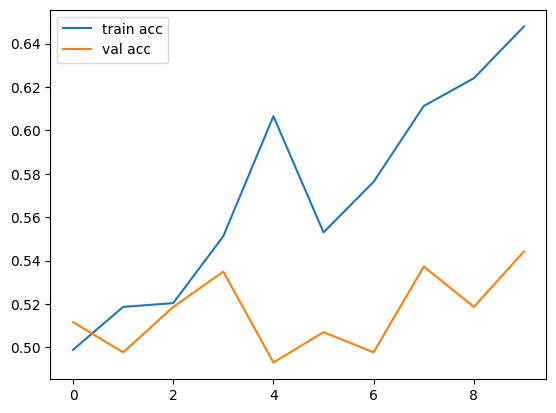

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [21]:
# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       213
           1       0.55      0.54      0.55       217

    accuracy                           0.54       430
   macro avg       0.54      0.54      0.54       430
weighted avg       0.54      0.54      0.54       430

Confusion Matrix:
[[116  97]
 [ 99 118]]


In [18]:
# Predict on test resumes
predicted_data = []
for filename in os.listdir(test_folder):
    if filename.endswith(".pdf"):
        path = os.path.join(test_folder, filename)
        text = clean_text(extract_text_from_pdf(path))
        seq = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(seq, maxlen=200)
        prediction = model.predict(padded)[0][0]
        result = "Accepted" if prediction >= 0.5 else "Rejected"

        predicted_data.append({
            "Filename": filename,
            "Prediction": result,
            "Name": extract_name(text),
            "Email": extract_email(text),
            "Phone": extract_phone(text),
            "Skills": ", ".join(extract_skills(text))
        })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [19]:
# Save to CSV
pd.DataFrame(predicted_data).to_csv("resume_predictions.csv", index=False)